In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import pickle
from IPython.display import display, HTML

from mlcysec2019 import utils

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision

from sklearn.metrics import accuracy_score
from sklearn.metrics  import classification_report

In [4]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'  
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

In [5]:
transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0,), (1,))]
     )

train_data = datasets.MNIST('~/data', train=True, download=False, transform=transform)
test_data = datasets.MNIST('~/data', train=False, download=False, transform=transform)

train_ratio = 0.85
train_num = len(train_data)
randn_indices = torch.randperm(train_num)
train_val_split = int(train_num*train_ratio)

train_idxs, val_idxs = randn_indices[:train_val_split], randn_indices[train_val_split:]

train_sampler = SubsetRandomSampler(train_idxs)
val_sampler = SubsetRandomSampler(val_idxs)

train_loader = DataLoader(train_data, batch_size=32, shuffle=False, num_workers=2, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=32, shuffle=False, num_workers=2, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

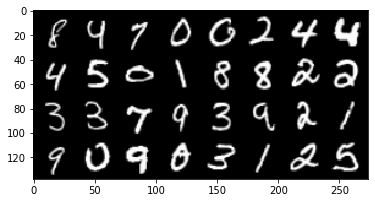

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

utils.imshow(torchvision.utils.make_grid(images))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def init_weight(m):
    update_weight = False

    if isinstance(m, torch.nn.Linear):
        update_weight = True
    elif isinstance(m, torch.nn.Conv2d):
        update_weight = True

    if update_weight:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [8]:
def train(net, epochs, criterion, optimizer, train_loader, val_loader):
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    train_acc_per_epoch = []
    val_acc_per_epoch = []

    global device

    for epoch in range(epochs):
        net.train()
        total = 0
        total_loss = 0.0
        correct = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            total += labels.size(0)

            _, pred = torch.max(outputs.data, 1)
            correct += (pred == labels).sum().item()
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        total_loss /= len(train_loader)
        acc = correct / total
        print('epoch = {}, loss={:.5f}, acc={:.5f}'.format(epoch, total_loss, acc))

        train_loss_per_epoch.append(total_loss)
        train_acc_per_epoch.append(acc)

        with torch.no_grad():
            net.eval()
            total_loss = 0.0
            correct = 0
            total = 0

            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()


            acc = correct / total
            total_loss /= len(val_loader)
            print('val loss: {:.5f} val acc: {:.5f} %%'.format(total_loss, acc))

            val_loss_per_epoch.append(total_loss)
            val_acc_per_epoch.append(acc)

        print("==================================")
    return train_loss_per_epoch, val_loss_per_epoch, train_acc_per_epoch, val_acc_per_epoch

In [9]:
def test(net, test_loader):

    global device

    test_num = test_loader.dataset.data.size(0)
    y_preds = np.zeros((test_num, ), dtype=np.int8)
    y_trues = np.zeros((test_num, ), dtype=np.int8)
    batch_size = test_loader.batch_size

    with torch.no_grad():
        net.eval()

        for i, (images, labels) in enumerate(test_loader):

            images = images.to(device)
            outputs = net(images)
            _, pred = torch.max(outputs.data, 1)

            label_size = labels.size(0)
            if label_size < batch_size:
                y_preds[i*label_size:(i+1)*label_size] = pred.cpu().numpy()
                y_trues[i*label_size:(i+1)*label_size] = labels.cpu().numpy()
                break

            y_preds[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()
            y_trues[i*batch_size:(i+1)*batch_size] = labels.cpu().numpy()      

        print(classification_report(y_trues, y_preds))
    
    return (sum(y_trues == y_preds)/test_num * 100)

In [10]:
epochs = 6
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_loss, val_loss, train_acc, val_acc = train(net, epochs, criterion, optimizer, train_loader, val_loader)

epoch = 0, loss=1.40315, acc=0.55731
val loss: 0.34001 val acc: 0.89789 %%
epoch = 1, loss=0.25204, acc=0.92345
val loss: 0.16084 val acc: 0.95044 %%
epoch = 2, loss=0.14770, acc=0.95457
val loss: 0.12616 val acc: 0.96189 %%
epoch = 3, loss=0.10719, acc=0.96733
val loss: 0.09171 val acc: 0.97144 %%
epoch = 4, loss=0.08912, acc=0.97198
val loss: 0.08359 val acc: 0.97378 %%
epoch = 5, loss=0.07715, acc=0.97565
val loss: 0.07277 val acc: 0.97789 %%


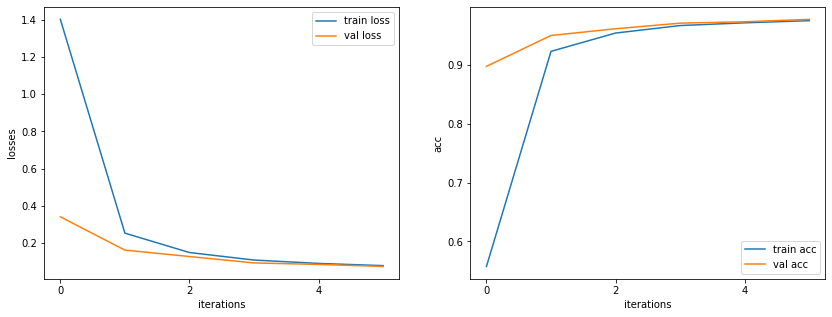

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2)
fig.set_size_inches((14, 5))
utils.plot_losses_for_train_test(ax0, train_loss, val_loss)
utils.plot_accs_for_train_test(ax1, train_acc, val_acc)

In [ ]:
test_acc = test(net, test_loader)

In [ ]:
model_path = 'models/mnist_net_e{}_a{}.pkl'.format(epochs, int(test_acc))
torch.save(net.cpu().state_dict(), model_path)

Acknowlegement: Shout out to my project partner Lin Yu-De who authored a significant amount of this code and to ML Cysec teaching staff who provided us with some starter code and project guidlines.